In [6]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import shap

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer


In [7]:
df = pd.read_csv("../data/Cornescu_Darius_new_features.csv")
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Condition2,SalePrice,LotArea_m^2,Price_per_m^2,ZoningScore,SubClassScore,LotAreaNorm,PDI,Price_per_m^2_norm,EVI
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,Norm,208500,785.03035,265.594827,0.835044,0.315789,0.033420,0.438780,0.247719,0.437530
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,Norm,181500,891.86880,203.505269,0.835044,0.105263,0.038795,0.377235,0.186350,0.364741
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,Norm,223500,1045.15875,213.843112,0.835044,0.315789,0.046507,0.442707,0.196568,0.411955
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,Norm,140000,887.22365,157.795613,0.835044,0.368421,0.038561,0.456112,0.141171,0.394783
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,Norm,250000,1324.79678,188.708188,0.835044,0.315789,0.060576,0.446927,0.171725,0.399533


In [8]:
target = "SalePrice"
X = df.drop(columns=[target])
Y = df[target]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MSSubClass          1460 non-null   int64  
 1   MSZoning            1460 non-null   object 
 2   LotFrontage         1201 non-null   float64
 3   LotArea             1460 non-null   int64  
 4   Street              1460 non-null   object 
 5   Alley               91 non-null     object 
 6   LotShape            1460 non-null   object 
 7   LandContour         1460 non-null   object 
 8   Utilities           1460 non-null   object 
 9   LotConfig           1460 non-null   object 
 10  LandSlope           1460 non-null   object 
 11  Neighborhood        1460 non-null   object 
 12  Condition1          1460 non-null   object 
 13  Condition2          1460 non-null   object 
 14  SalePrice           1460 non-null   int64  
 15  LotArea_m^2         1460 non-null   float64
 16  Price_

In [10]:
numerical_col = X.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical_col = X.select_dtypes(include=["object"]).columns.tolist()

print("Numerical columns:", numerical_col)
print("Categorical columns:", categorical_col)

Numerical columns: ['MSSubClass', 'LotFrontage', 'LotArea', 'LotArea_m^2', 'Price_per_m^2', 'ZoningScore', 'SubClassScore', 'LotAreaNorm', 'PDI', 'Price_per_m^2_norm', 'EVI']
Categorical columns: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2']


In [11]:
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numerical_col),
    ('cat', categorical_transformer, categorical_col)
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)   

In [13]:
pipeline.fit(X_train, Y_train)
Y_pred = pipeline.predict(X_test)

In [14]:
mae = mean_absolute_error(Y_test, Y_pred)
r2  = r2_score(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)

print("MAE:", mae)
print("R2:", r2)
print("MSE:", mse)

MAE: 11509.804794520547
R2: 0.9072723778476465
MSE: 711251110.3253424


# SHAP - integration


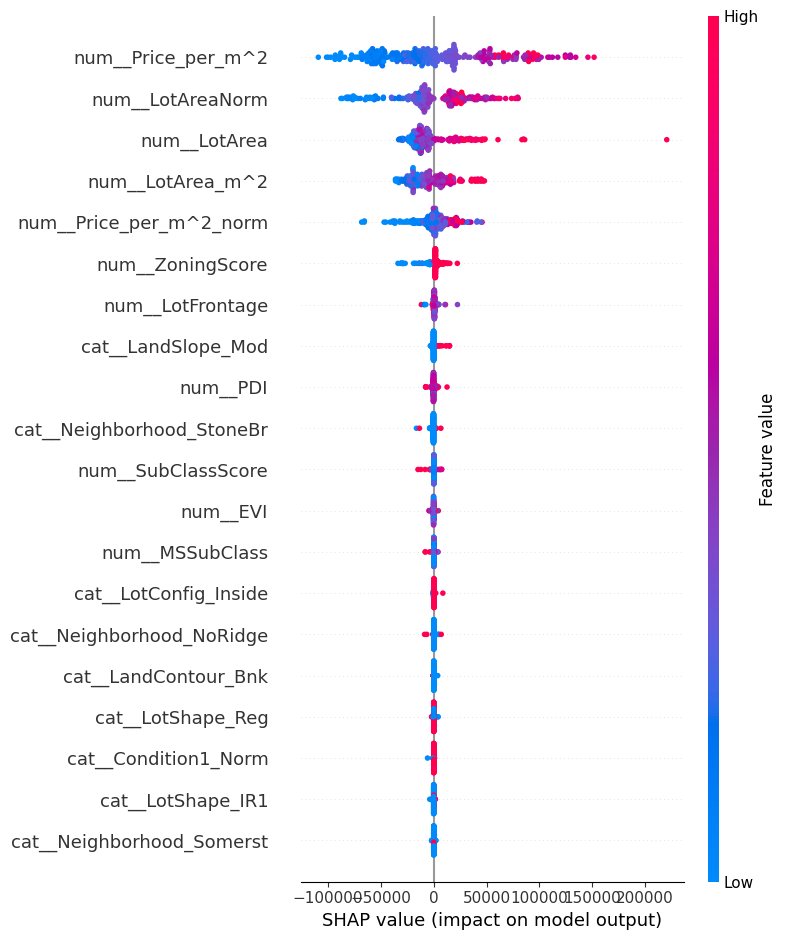

In [15]:
preprocessor = pipeline.named_steps['preprocessor']
regression = pipeline.named_steps['model']

X_test_preprocessed = preprocessor.transform(X_test)
X_test_preprocessed = X_test_preprocessed.toarray()

explainer = shap.Explainer(regression)
shap_values = explainer.shap_values(X_test_preprocessed)

shap.summary_plot(shap_values, X_test_preprocessed, feature_names=preprocessor.get_feature_names_out())

We can observe that `Price_per_m^2_norm` and `LotArea` have the strongest impact on the predicted sale price.

Higher values of `Price_per_m^2_norm` tend to significantly increase the estimated price, indicating that properties with a higher cost per square meter are systematically evaluated as more expensive. 

In contrast, large `LotArea` values have a mixed effect: for some properties, a larger land area increases the price, while in other cases it may indicate less central or less desirable locations, which lowers the price. This variability explains the wide spread of SHAP values around zero.

Additionally, categorical features from the `Neighborhood` and `LotShape` groups show localized effects, suggesting that both the geographical area and the shape of the lot influence property valuation.



In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer()),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numerical_col),
    ('cat', categorical_transformer, categorical_col)
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])


In [18]:
param_grid = {
    "preprocessor__num__imputer__n_neighbors": [2, 3, 5, 7, 9],
    "model__max_depth": [None, 5, 10, 15, 20],
    "model__min_samples_split": [2, 5, 10]
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_train, Y_train)

print("Best parameters:", grid.best_params_)
best_model = grid.best_estimator_

Best parameters: {'model__max_depth': 15, 'model__min_samples_split': 5, 'preprocessor__num__imputer__n_neighbors': 9}


In [19]:
Y_pred = best_model.predict(X_test)
mae = mean_absolute_error(Y_test, Y_pred)
r2  = r2_score(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)

print("Tuned MAE:", mae)
print("Tuned R2:", r2)
print("Tuned MSE:", mse)

Tuned MAE: 11753.714041095891
Tuned R2: 0.9097393044804135
Tuned MSE: 692328978.3228216
